In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
def generate_sobel_kernel(kSize):
    if kSize % 2 == 0:
        raise ValueError("Kernel size must be odd")
    # kernel y = kernel x transpose
    kernel_x = np.zeros((kSize, kSize), dtype=np.float32)
    kernel_x[:,0] = -1
    kernel_x[:,-1] = 1
    for i in range(1, kSize - 1):
        kernel_x[i, 0] = -2
        kernel_x[i, -1] = 2
    kernel_y = kernel_x.T
    return kernel_x, kernel_y

def getGradient(image, kSize=3):
    kernel_x, kernel_y = generate_sobel_kernel(kSize)
    image = image.astype(np.float32)
    pad = kSize // 2
    padded_image = np.pad(image, pad, mode = 'reflect')
    # 套用 kernel_x, kernel_y
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+kSize, j:j+kSize] * kernel_y)
    return gradient_x, gradient_y
# Canny
def canny(image, kSize=3, weak=75, strong=255):
    gradient_x, gradient_y = getGradient(image)
    # 找出梯度的大小跟方向
    gra_mag = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gra_dir = np.arctan2(gradient_y, gradient_x)
    supressed = np.zeros_like(gra_mag)
    # non-maxima supression, 保留邊緣點
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            angle = gra_dir[i, j]
            mag = gra_mag[i, j]
            
            # 旋轉角度, 0 ~ 180
            angle = angle * 180 / np.pi
            if angle < 0:
                angle += 180
            
            # 看看自己的鄰居, 僅保留最大的鄰居
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [gra_mag[i, j-1], gra_mag[i, j+1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [gra_mag[i-1, j-1], gra_mag[i+1, j+1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [gra_mag[i-1, j], gra_mag[i+1, j]]
            else:
                neighbors = [gra_mag[i-1, j+1], gra_mag[i+1, j-1]]
            if mag >= max(neighbors):
                supressed[i,j] = mag
    # 兩個 threshold, 來找出強強邊緣跟弱邊緣點
    # numpy 好好用!
    result_image = np.zeros_like(supressed, dtype=np.uint8)
    strong_i, strong_j = np.where(supressed >= strong)
    weak_i, weak_j = np.where((supressed >= weak) & (supressed < strong))
    result_image[strong_i, strong_j] = strong
    result_image[weak_i, weak_j] = weak
    # 邊緣追蹤
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if result_image[i, j] == weak:
                # 檢查弱邊緣周圍八個點有沒有強邊緣, 有的話就保留
                if strong in [result_image[i+ii, j+jj] for ii in [-1, 0, 1] for jj in [-1, 0, 1]]:
                    result_image[i, j] = 255
                else:
                    result_image[i, j] = 0
    return result_image


In [5]:
def create_r_table(image, kSize=3): 
    # r_table[角度] = [r1(dx, dy), r2, r3, ...]
    r_table = {} 
    
    center_point = (image.shape[0] // 2, image.shape[1] // 2)
    # 梯度大小與方向
    gradient_x, gradient_y = getGradient(image, kSize)
    direction = np.arctan2(gradient_y, gradient_x)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # 邊緣點 (圖片已經過 canny)
            if image[i, j] > 0: 
                theta = np.rad2deg(direction[i, j])
                # 距離中心點的向量 (dx, dy)
                r = [i - center_point[0], j - center_point[1]]
                # 沒有對應的角度, 就初始化
                if theta not in r_table:
                    r_table[theta] = []
                r_table[theta].append(r)
    # 獲得描述圖片的 r_table
    return r_table

def detect_object(image, r_table, kSize=3, angle_step=1):
    # 梯度大小與方向
    gradient_x, gradient_y = getGradient(image, kSize)
    direction = np.arctan2(gradient_y, gradient_x)

    # 初始化投票機器, 
    # shape = (image.shape[0], image.shape[1], 360 // angle_step)
    accumulator = np.zeros((*image.shape, len(range(0, 360, angle_step))), dtype=np.int32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] > 0: # 邊緣點
                theta = np.rad2deg(direction[i, j])
                # 角度存在
                if theta in r_table:
                    # 向量(dx, dy) 存在
                    for r in r_table[theta]:
                        # 投票時間! 
                        for angle_idx, angle in enumerate(range(0, 360, angle_step)):
                            angle = np.deg2rad(angle)
                            # 考量到可能變換的角度, 轉整數
                            x_c = int(i - r[0] * np.cos(angle) + r[1] * np.sin(angle))
                            y_c = int(j - r[0] * np.sin(angle) - r[1] * np.cos(angle))
                            # 想投票的目標經過轉換依舊在範圍內
                            if 0 <= x_c < image.shape[0] and 0 <= y_c < image.shape[1]:
                                accumulator[x_c, y_c, angle_idx] += 1
    return accumulator
def display_result(image, accumulator, angle_step=1, box_size=(50, 50), ref='', tmp=''):
    # 找到得票數最多的候選位置
    x, y, angle_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
    angle = angle_idx * angle_step
    
    # 將圖片轉換為 0~255 的範圍
    result_image = np.clip(image, 0, 255).astype(np.uint8)

    # 顯示結果圖片
    fig, ax = plt.subplots()
    ax.imshow(result_image, cmap="gray")

    # 繪製中心點
    ax.scatter(y, x, c='red', s=20, label=f"Center (x={y}, y={x}, angle={angle}°)")

    # 繪製方框
    box_height, box_width = box_size
    top_left_x = y - box_width // 2
    top_left_y = x - box_height // 2
    rect = patches.Rectangle(
        (top_left_x, top_left_y),  
        box_width,                
        box_height,
        linewidth=1,
        edgecolor='yellow',
        facecolor='none'
    )
    ax.add_patch(rect)

    ax.legend(loc='upper right', fontsize=12)
    ax.set_title(f"{ref}, {tmp}, angle_step={angle_step}", fontsize=16)
    ax.axis("off")
    plt.savefig(f'result/{ref}, {tmp}.png')
    plt.show()



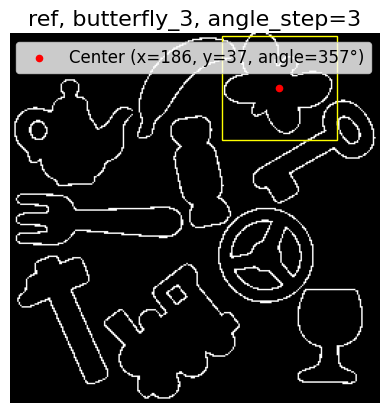

In [ ]:
def main():
    references = ['ref','ref', 'ref', 'Time', 'Time', 'Time', 'ref', 'ref']
    template = ['tea_0', 'tea_180', 'tea_45', 'Time_tmp', 'Time_tmp_0', 'Time_tmp_180', 'train_12', 'cup_64']
    angles = [360, 180, 45, 90, 90, 180, 10, 30, 3, 90]
    # references = ['ref', 'animal_well']
    # template = ['butterfly_3', 'animal'] it takes forever (like 1 hour), don't do it. 
    angles = [3, 90]
    for ref, tmp, angle_step in zip(references, template, angles):
        # 讀取處理後的圖片
        image = cv2.imread(f'images/{ref}.png', cv2.IMREAD_GRAYSCALE)
        template = cv2.imread(f'images/{tmp}.png', cv2.IMREAD_GRAYSCALE)
        canny_image = canny(image)
        canny_template = canny(template)   
        # 中間點
        r_table = create_r_table(canny_template)
        # 在 image 當中找 r_table 標示出的特徵
        result = np.array(canny_image, dtype=np.float32)
        accumlator = detect_object(result, r_table, angle_step=angle_step)
        display_result(image, accumlator, box_size = (template.shape[0], template.shape[1]), ref=ref, tmp=tmp, angle_step=angle_step)

if __name__ == '__main__':
    main()